In [1]:
##Import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta

# import all libraries and dependencies for data visualization
pd.options.display.float_format='{:.4f}'.format
plt.rcParams['figure.figsize'] = [8,8]
pd.set_option('display.max_columns', 350)
pd.set_option('display.max_colwidth', -1) 
pd.set_option("display.max_rows", 500)
sns.set(style='darkgrid')
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker


# import all libraries and dependencies for machine learning
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import StandardScaler

from sklearn.compose import make_column_transformer


import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit, Lasso, LassoLarsIC, ElasticNet, ElasticNetCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFECV, SelectFromModel
from sklearn.model_selection import train_test_split


from scipy import stats
from scipy.stats import norm, kurtosis, skew

# Import specific libraries
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor



# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p
from patsy import dmatrices


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFECV, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA, KernelPCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit, Lasso, LassoLarsIC, ElasticNet, ElasticNetCV
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor, HuberRegressor, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb

from patsy import dmatrices

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


pd.set_option('expand_frame_repr', False)

In [2]:
#Loading datasets
%store -r all_data
%store -r y_train
%store -r cols
# %store -r train
# %store -r test
%store -r df
%store -r all_viejo

In [3]:
all_data.shape

(2908, 256)

In [4]:
cols

Index(['LotFrontage', 'Street', 'LotShape', 'LandSlope', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'Remod', 'IsNew'],
      dtype='object', length=188)

In [5]:
## F E A T U R E   S E L E C T I O N 

In [6]:
###SPLITING INTO TRAIN AND TEST SETS FOR THE ANALYSIS

"""Para el proceso de feature selection se utilizará al dataset sin los polynomial features, ya que
se quiere analizar los features originales. Recordar que cols con tiene las columnas seleccionadas luego del
análisis de correlación y multicollinearity"""

# #Creo el train y se resetea también su index
train = all_data.iloc[:len(y_train), :].reset_index(drop = True, inplace = False)
train = train.loc[:, cols].reset_index(drop = True, inplace = False)

# #Creo el test y se resetea también su index
test = all_data.iloc[len(y_train):, :].reset_index(drop = True, inplace = False)
test= test.loc[:, cols].reset_index(drop = True, inplace = False)

# #Reseteo además el y_train en su index

y_train = y_train.reset_index(drop = True, inplace = False)

train.shape

(1449, 188)

In [7]:
##FEATURES ELECTION USING WRAPPER METHODS

##Rescaling: Primero se hace rescaling de los datos usando RobustScaler ya que permite que la tranaformación sea robusta a
#outliers
 
scale = RobustScaler()
# Data without Polynomials
X = pd.DataFrame(scale.fit_transform(train[cols]), columns= cols)

#First method: Backward Elimination using p-values
"""Algoritmo: se hace regresion del dataset y se va eliminando progresivamente
el feature que muestre el mayor p-value que sea > p_threshold hasta que no haya cambios significativos en 
los resultados"""

##MODULO MAE: BACKWARD ELIMINATION USING P-VALUES
def backwardElimination(X, y, cols, thres): 
    """#input a dataset x,y, threshold and columns of features; output: columns of selected features"""
    #Ajuste y cálculo del p_value maximo
    regressor = LinearRegression()
    regressor = sm.OLS(y, X[cols]).fit()
    max_val = np.max(regressor.pvalues)
    
    while max_val > thres:
        
        #Identifico el feature con maximo p_value y actualizo las columnas de features
        feat_to_discard = regressor.pvalues[regressor.pvalues.values.astype(float) == max_val].index[0]
        cols = cols.drop(feat_to_discard)
        
        #Vuelvo a ajustar
        regressor = LinearRegression()
        regressor = sm.OLS(y, X[cols]).fit()
        max_val = np.max(regressor.pvalues)
       
    print("We have selected {} features from BackwardElimination".format(len(cols)))
        
          
    return cols, regressor

pv_cols, regressor = backwardElimination(X, y_train, cols, thres = 0.051)

We have selected 107 features from BackwardElimination


In [8]:
pv_cols

Index(['Street', 'LandSlope', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'BsmtHalfBath',
       ...
       'MoSold_6', 'MoSold_7', 'MoSold_8', 'MoSold_9', 'MoSold_11',
       'MoSold_12', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'Remod'],
      dtype='object', length=107)

In [9]:
ln_model=sm.OLS(y_train,X)
result=ln_model.fit()
print(result.summary2())

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.994    
Dependent Variable:     SalePrice        AIC:                         3961.2009
Date:                   2020-07-20 16:37 BIC:                         4953.5832
No. Observations:       1449             Log-Likelihood:              -1792.6  
Df Model:               188              F-statistic:                 1390.    
Df Residuals:           1261             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.995            Scale:                       0.79880  
--------------------------------------------------------------------------------
                           Coef.   Std.Err.     t      P>|t|    [0.025    0.975]
--------------------------------------------------------------------------------
LotFrontage                0.0392    0.0353    1.1124  0.2662   -0.0300   0.1084
Street                    -1.6017    0.4800   -3.3368  0.000

multicollinearity or other numerical problems.


In [10]:
selected_feats, regressor = backwardElimination(X,y_train.values.reshape(-1,1),cols, 0.051)

We have selected 107 features from BackwardElimination


In [11]:
##Chequeamos el resultado corriendo  el OLS en X[selected_features]

regressor = LinearRegression()
regressor = sm.OLS(y_train.values.reshape(-1,1), X[selected_feats]).fit()
print(regressor.summary())


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              2454.
Date:                Mon, 20 Jul 2020   Prob (F-statistic):                        0.00
Time:                        16:37:23   Log-Likelihood:                         -1833.9
No. Observations:                1449   AIC:                                      3882.
Df Residuals:                    1342   BIC:                                      4447.
Df Model:                         107                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [12]:
#Second Method: RECURSIVE FEATURE ELIMINIATION - RFE
"""Definition: Utilizando un estimador (modelo) el algoritmo parte con todos los features y va eliminando aquellos
que menos contribuyen al óptimo performance del modelo, hasta llegar a los n features estipulados"""
"""Links: https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15
Lasso y Ridge Regression: https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b"""

'Links: https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15\nLasso y Ridge Regression: https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b'

In [13]:
"""Usaremos RFECV (REF with crossvalidation included), tomando como estimator LASSO Regression"""

'Usaremos RFECV (REF with crossvalidation included), tomando como estimator LASSO Regression'

In [14]:
#Definimos el estimator: LASSO Regression
ls = Lasso(alpha = 0.0005, max_iter = 161, selection = 'cyclic', tol = 0.002, random_state = 101)

#Instanciamos RFECV
rfecv = RFECV(estimator=ls, n_jobs = -1, step=1, scoring = 'neg_mean_squared_error' ,cv=5)

#Ejecutamos el fit
rfecv.fit(X,y_train)

#Features seleccionados
sel_rfecv = rfecv.get_support() #entrega lista con booleanos True/false si fueron o no seleccionados
sel_cols_rfecv = cols[sel_rfecv]

#Resultados
print("RFECV selected {} features".format(len(sel_cols_rfecv)))
print("Selected Features:", sel_cols_rfecv)


RFECV selected 79 features
Selected Features: Index(['LotFrontage', 'LandSlope', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2',
       'HeatingQC', 'CentralAir', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'GarageFinish', 'PavedDrive', 'OpenPorchSF', 'EnclosedPorch', 'YrSold',
       'TotalPoints', 'GarageArea_x_Car', 'ConstructArea', 'LotAreaMultSlope',
       'TotBathrooms', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_50',
       'MSSubClass_70', 'MSSubClass_160', 'MSZoning_FV', 'MSZoning_RM',
       'Alley_Pave', 'LandContour_Lvl', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neig

In [15]:
####IMPORTANTE: ALGUNOS METODOS COMO SBS VAN CALCULANDO A MEDIDA QUE SE VAN ENCONTRANDO CON LOS FEATURES
##POR TANTO EL ORDEN EN QUE VAN LAS COLUMNAS EN EL DATASET INFLUYE EN LOS FEATURES QUE SELECCIONA.
##ME OCURRIO CON SBS, DONDE EL VIEJO TENIA UN DATAFRAME DF QUE TENIA UN ORDEN DIFERENTE DE COLUMNAS
##QUE MI X, POR LO QUE DABA UN RESULTADO DISTINTO. HICE ELÑ SIGUIENTE CAMBIO Y SE SOLUCIONO:
## X = X[df.columns]
##Con eso quedaron todas las columnas en el mismo orden que en df
##EN TODO CASO, PARA NO CONFUNDIRMOE EN ESTE NOTEBOOK IMPORTARÉ LAS COLUMNAS DIRECTO DESDE EL VIEJO

###CAMBIO DE ORDEN EN COLUMNAS:
cols_viejo = ['LotFrontage',
 'Street',
 'LotShape',
 'LandSlope',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'CentralAir',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'GarageYrBlt',
 'GarageFinish',
 'PavedDrive',
 'OpenPorchSF',
 'EnclosedPorch',
 'Fence',
 'MiscVal',
 'YrSold',
 'TotalExtraPoints',
 'TotalPoints',
 'GarageArea_x_Car',
 'ConstructArea',
 'Garage_Newest',
 'LotAreaMultSlope',
 'TotBathrooms',
 'MSSubClass_120',
 'MSSubClass_160',
 'MSSubClass_180',
 'MSSubClass_190',
 'MSSubClass_20',
 'MSSubClass_30',
 'MSSubClass_40',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_70',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RM',
 'Alley_NA',
 'Alley_Pave',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'Neighborhood_Blmngtn',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Neighborhood_Timber',
 'Neighborhood_Veenker',
 'Condition1_Artery',
 'Condition1_Feedr',
 'Condition1_Norm',
 'Condition1_PosA',
 'Condition1_RRAe',
 'Condition1_RRAn',
 'Condition1_RRNe',
 'Condition1_RRNn',
 'Condition2_Artery',
 'Condition2_Feedr',
 'Condition2_Norm',
 'Condition2_PosA',
 'Condition2_PosN',
 'BldgType_2fmCon',
 'BldgType_Twnhs',
 'HouseStyle_15Fin',
 'HouseStyle_15Unf',
 'HouseStyle_25Unf',
 'HouseStyle_SFoyer',
 'HouseStyle_SLvl',
 'RoofStyle_Gambrel',
 'RoofStyle_Hip',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'RoofMatl_CompShg',
 'RoofMatl_TarGrv',
 'RoofMatl_WdShake',
 'RoofMatl_WdShngl',
 'Exterior1st_AsbShng',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_BrkFace',
 'Exterior1st_CemntBd',
 'Exterior1st_HdBoard',
 'Exterior1st_Plywood',
 'Exterior1st_Stucco',
 'Exterior1st_WdSdng',
 'Exterior1st_WdShing',
 'Exterior2nd_AsbShng',
 'Exterior2nd_AsphShn',
 'Exterior2nd_BrkCmn',
 'Exterior2nd_BrkFace',
 'Exterior2nd_CmentBd',
 'Exterior2nd_HdBoard',
 'Exterior2nd_ImStucc',
 'Exterior2nd_MetalSd',
 'Exterior2nd_Plywood',
 'Exterior2nd_Stone',
 'Exterior2nd_Stucco',
 'Exterior2nd_WdSdng',
 'Exterior2nd_WdShng',
 'MasVnrType_BrkFace',
 'MasVnrType_Stone',
 'Foundation_BrkTil',
 'Foundation_PConc',
 'Foundation_Slab',
 'Foundation_Stone',
 'Foundation_Wood',
 'Heating_GasA',
 'Heating_GasW',
 'Heating_Grav',
 'Heating_Wall',
 'Electrical_FuseA',
 'Electrical_FuseF',
 'Electrical_FuseP',
 'GarageType_Basment',
 'GarageType_BuiltIn',
 'GarageType_CarPort',
 'GarageType_Detchd',
 'GarageType_NA',
 'MiscFeature_Othr',
 'MiscFeature_Pool',
 'MiscFeature_Shed',
 'MoSold_1',
 'MoSold_11',
 'MoSold_12',
 'MoSold_2',
 'MoSold_3',
 'MoSold_4',
 'MoSold_5',
 'MoSold_6',
 'MoSold_7',
 'MoSold_8',
 'MoSold_9',
 'SaleType_CWD',
 'SaleType_Con',
 'SaleType_ConLD',
 'SaleType_ConLI',
 'SaleType_ConLw',
 'SaleType_Oth',
 'SaleType_WD',
 'SaleCondition_Abnorml',
 'SaleCondition_AdjLand',
 'SaleCondition_Alloca',
 'SaleCondition_Family',
 'Remod',
 'IsNew']
X = X[cols_viejo]

Best Score:0.931773881845142
Number of best features selected:52
Selected features by SBS: ['OverallCond', 'MasVnrArea', 'BsmtCond', 'BsmtFinType2', 'CentralAir', 'HalfBath', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageFinish', 'PavedDrive', 'EnclosedPorch', 'YrSold', 'TotalPoints', 'ConstructArea', 'LotAreaMultSlope', 'TotBathrooms', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_60', 'LandContour_Lvl', 'LotConfig_CulDSac', 'LotConfig_FR2', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'Condition1_RRAe', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofMatl_CompShg', 'Exterior1st_WdSdng', 'Exterior2nd_HdBoard', 'Exterior2nd_Plywood', 'Foundation_BrkTil', 'Foundation_PConc', 'Foundation_Slab', 'Heating_GasW', 'GarageType_CarPort', 'MoSold_11', 'MoSold_3', 'MoS

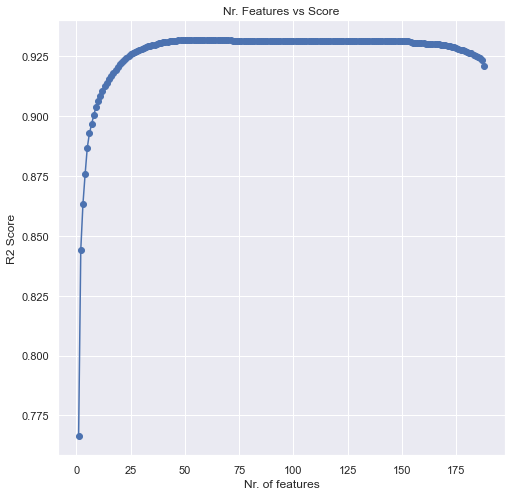

In [16]:
###Third Method: SEQUENTIAL FEATURE SELECTION
"""Computationally very expensive, but we will apply it to get selected features to add to all other
techniques we will try"""

from itertools import combinations # nos permitirá generar todas las combinaciones posibles de un arreglo o lista

#METHOD: Sequential Backward Selection (SBS)
class SBS():
    def __init__(self, estimator, k_features, scoring = r2_score, test_size = 0.25, random_state = 101):
        self.estimator = estimator
        self.scoring = scoring
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
        #Fit: método principal. Toma un dataset y entrega la combinacion de features que optimice el rendimiento
    def fit(self, X,y):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = self.test_size, random_state = self.random_state)
        dim = X_train.shape[1] #nro inicial de features, que es el total
#         df_x_train = pd.DataFrame(X_train, columns = X.columns)
#         display(df_x_train.head())
        self.indices_ = list(range(dim)) #lista con los indices de todos los features iniciales 
        self.subsets_ = [self.indices_] # Crea una matriz de 1 fila por n columnas de los features inciales
       
       
        #Calcula el score inicial con todos los features
        score = self._calc_score(X_train, X_test, y_train, y_test, self.indices_)
        self.scores_ = [score] #crea una lista y agrega el primer score
        
        #Calcula los scores para cada una de las combinaciones posibles de r features por cada nro de features, partiendo por dim -1:
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r = dim-1): #se parte por dim -1 porque ya arriba se calculó para el total de los features
                score = self._calc_score(X_train, X_test, y_train, y_test, list(p))
                scores.append(score) #guardo el score que esta combinación sacó
                subsets.append(list(p)) #agrego la combinación aquí
                               
                
            #encuentro ahora la combinación con mejor score
            best = np.argmax(scores)
            self.indices_ = subsets[best] # en self indices queda la mejor combinación
            self.subsets_.append(self.indices_) #agrego a subsets esta combinacion como un bloque []
            dim -= 1 #actualizo el dim para volver al while
            self.scores_.append(scores[best]) #agrego el score actual a scores_

        self.k_score = self.scores_[-1] #k_score es el último valor guardado
        return self
    
    
    def transform(self, X): #retorna el X actualizado usando solo los mejores indices seleccionados
        return X.iloc[:, self.indices_]
    

        
    def _calc_score(self, X_train, X_test, y_train, y_test, indices): #calcula el score de cada combinacion de features
        self.estimator.fit(X_train.iloc[:, indices], y_train)
        y_predict = self.estimator.predict(X_test.iloc[:, indices])
        score = self.scoring(y_test, y_predict)
        return score
    
    
#Corremos SBS generando primero los parámetros...
score = r2_score
ls = Lasso(alpha = 0.0005, max_iter = 161, selection = 'cyclic', tol = 0.002, random_state = 101)

#Instanciamos SBS para que haga la selección revisando hasta llegar a 1 feature
sbs = SBS(estimator = ls , k_features = 1, scoring = score)


sbs.fit(X,y_train)

##Ploteamos para ver cuál es la combinación y nro de features con mejor desempeño (r2_score)
k_features_plot = [len(k) for k in sbs.subsets_] 
k_scores = [sc for sc in sbs.scores_]

plt.title("Nr. Features vs Score")
plt.xlabel("Nr. of features")
plt.ylabel("R2 Score")
plt.plot(k_features_plot, k_scores, marker = "o")

print("Best Score:{}".format(max(sbs.scores_)))
SBS = list(X.columns[list(sbs.subsets_[max(np.arange(0, len(sbs.scores_))[(sbs.scores_==max(sbs.scores_))])])])
print("Number of best features selected:{}".format(len(SBS)))

print("Selected features by SBS:", SBS)




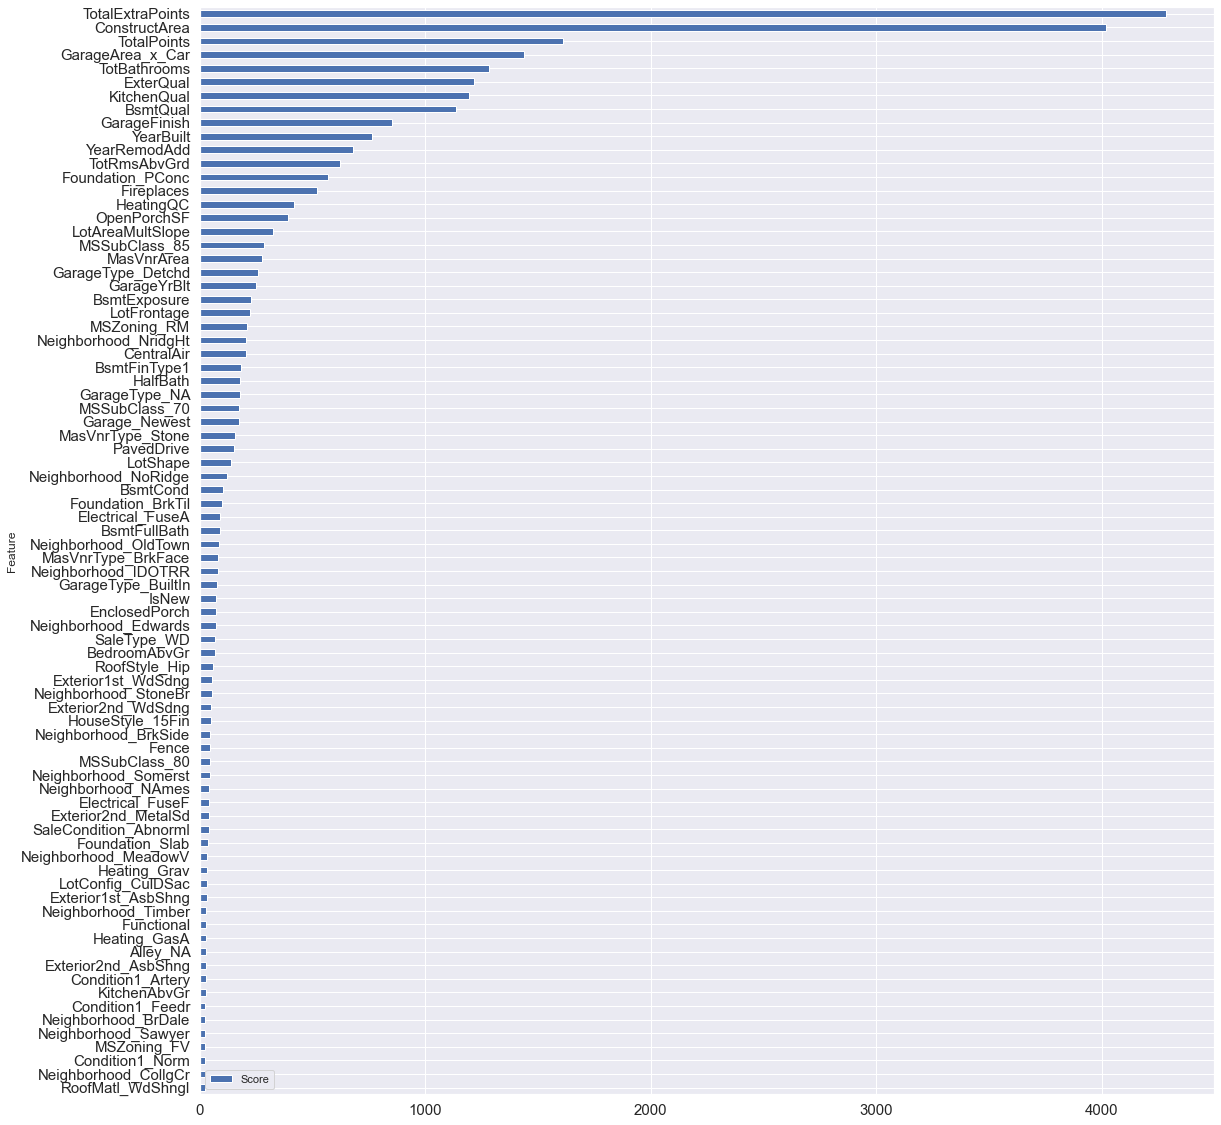

In [17]:
##FEATURE SELECTION BY FILTER METHODS###
"""Se trata de métodos utilizados duranmte la etapa de preprocessing, antes de modelar.
Según los tipos de variables,s e aplica un test distinto para ver su grado de correlación con target (ANOVA, Chi2, Pearson)
y de acuerdo a eso se rankean.
These methods are particularly good for gaining a better understanding of data, but not necessarily for optimizing 
the feature set for better generalization."""
"""Más informaxción: https://www.analyticsvidhya.com/blog/2016/12/
introduction-to-feature-selection-methods-with-an-
example-or-how-to
-select-the-right-
variables/#:~:text=Filter%20methods%20are%20generally%20used,is%20a%20subjective%20term%20here."""

###Utilizaremos el método SelectKBest de Sklearn como filter metodo de seleccion de features: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

##METODO SELECTKBEST:
#Hay dos modalidades: usando fregression o mutual info regression

#Con f_regression como funcion para rankear
skb = SelectKBest(score_func = f_regression, k = 80) #seleccionaremos los mejores 80 feats ordenándolos por su F-value
skb.fit(X, y_train)
select_features_kbest = skb.get_support() #entrega lista con booleanos True/false si fueron o no seleccionados
kbest_FR = cols[select_features_kbest] # columnas con los features seleccionados
scores = skb.scores_[select_features_kbest] # extrae los scores de los features seleccionados
feature_scores = pd.DataFrame([(item, score) for item,score in zip(kbest_FR, scores)], columns = ["Feature", "Score"])
#Ploteamos
fig = plt.figure(figsize= (40,20))
f1 = fig.add_subplot(121)
feature_scores.sort_values(by = "Score", ascending = True).plot(y = "Score", x = "Feature", kind = "barh",
                                                                 ax = f1, fontsize = 15, grid = True)


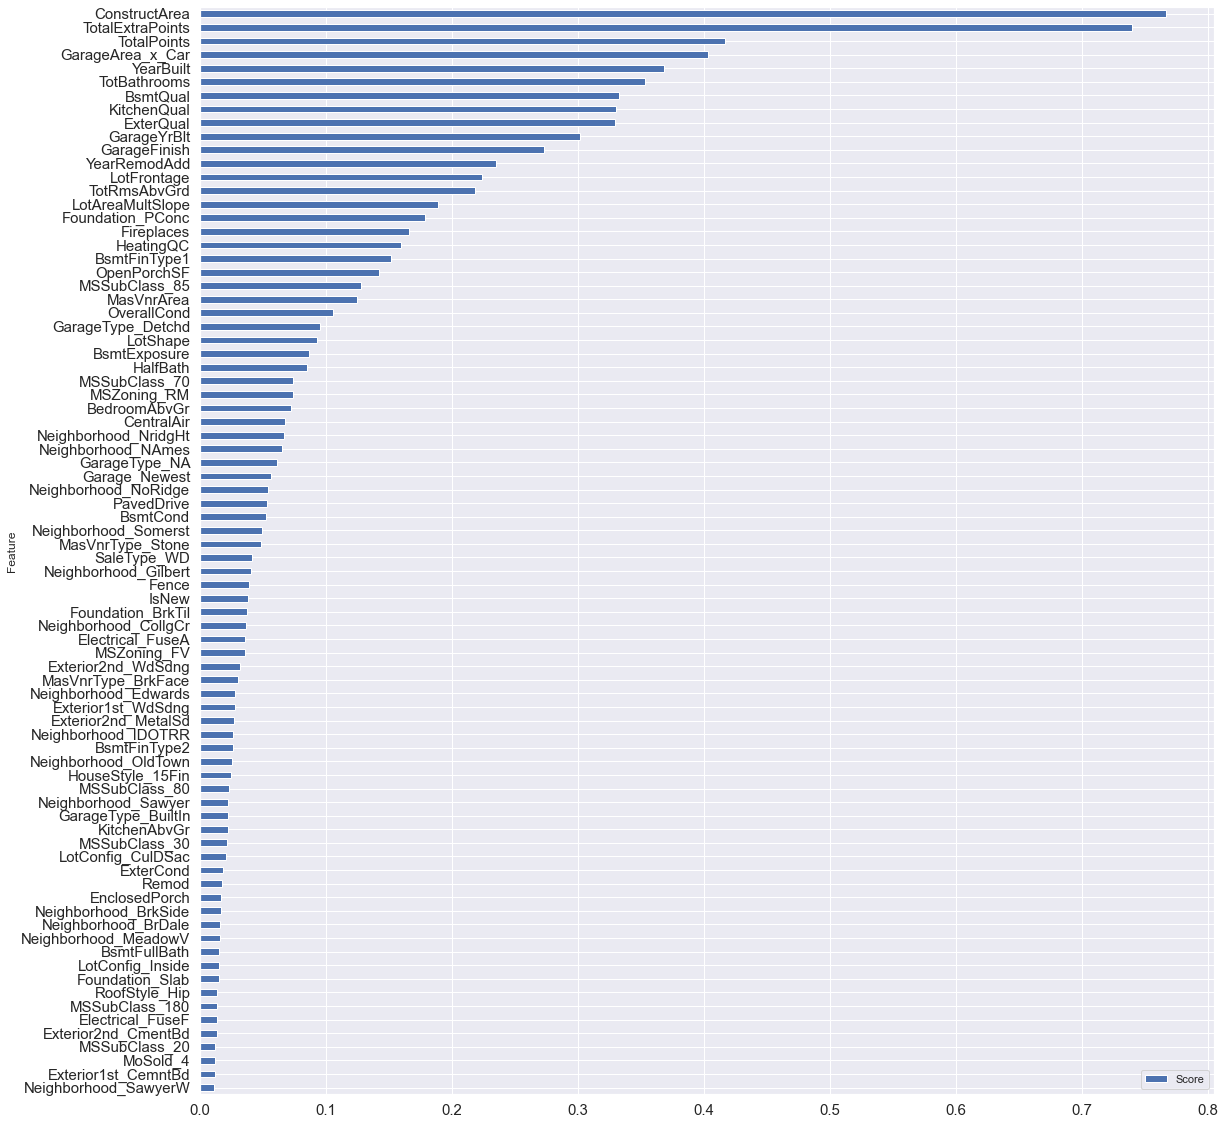

In [18]:
##Con mutual_info_regression como funcion para rankear

skb = SelectKBest(score_func=mutual_info_regression, k = 80)
skb.fit(X, y_train)
select_features_kbest = skb.get_support() #lista d booleanos con True si fue seleccionado dentro de los k mejores
kbest_MIR = cols[select_features_kbest] #lista con los nombres de los feats seleccionados por este metodo
scores = skb.scores_[select_features_kbest] #extrae los scores de los features seleccionado
feature_scores = pd.DataFrame([(item, score) for item, score in zip(kbest_MIR, scores)], columns = ["Feature", "Score"])

#Ploteamos
fig2 = plt.figure(figsize = (40,20))
f2 = fig2.add_subplot(121)
feature_scores.sort_values(by = "Score", ascending = True).plot(y="Score", x= "Feature", kind = "barh",
                                                               ax = f2, fontsize = 15, grid = True)



In [19]:
####NOTA: EL VIEJO TIENE UN ERROR AL CALCULAR EL DATAFRAME DEL METODO MIR, YA QUE HACE:
##feature_scores = pd.DataFrame([(item, score) for item,score in zip(kbest_FR, scores)], columns = ["Feature", "Score"])
##EN VEZ DE:
###pd.DataFrame([(item, score) for item, score in zip(kbest_MIR, scores)], columns = ["Feature", "Score"])
##POR TANTO HAY QUIZA UNA DIFERENCIA MAS ADELANTE EN SUS ELECCION TOTAL DE FEATURES DE TODOS LOS METODOS

In [20]:
###FEATURE SELECTION BY EMBEDDED METHODS###


In [21]:
#Feature selection using XGBoost 
"""Puede utilizarse el método de Feature Importance de XGBoot para identificar los features con mayor influencia.
Toda la información en: 
https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
https://medium.com/@gabrieltseng/gradient-boosting-and-xgboost-c306c1bcfaf5
https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/#:~:text=Generally%2C%20importance%20provides%20a%20score,the%20higher%20its%20relative%20importance.

"""

'Puede utilizarse el método de Feature Importance de XGBoot para identificar los features con mayor influencia.\nToda la información en: \nhttps://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\nhttps://medium.com/@gabrieltseng/gradient-boosting-and-xgboost-c306c1bcfaf5\nhttps://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/#:~:text=Generally%2C%20importance%20provides%20a%20score,the%20higher%20its%20relative%20importance.\n\n'

In [22]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

###Módulo para Feature selection using XGBOOST
"""Modulo usa XGBoost para extraer los features mas importantes, iterando con varios umbrales de corte (thresholds)
y seleccionando el subset con mejor rendimiento al hacer correr el XGBoost"""

##Split data into train and test sets for training with XGBOOST
X_train, X_test, y, y_test = train_test_split(X, y_train, test_size = 0.30, random_state = 101)

#Fit then model in all training data
"""There are many types of importance_type factor to setup, but we will use GAIN, which mean we will give importance
to each feature according to the reduction of loss as a result of splitting with it (The average training loss reduction
gained when using a feature for splitting.)"""

model = XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0, max_delta_step=0, 
                      random_state=101, min_child_weight=1, missing=None, n_jobs=4,  
                      scale_pos_weight=1, seed=None, silent=True, subsample=1, verbosity = 0) #importance_type es gain por defecto

#Model fit
model.fit(X_train,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=101,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=101,
             silent=True, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

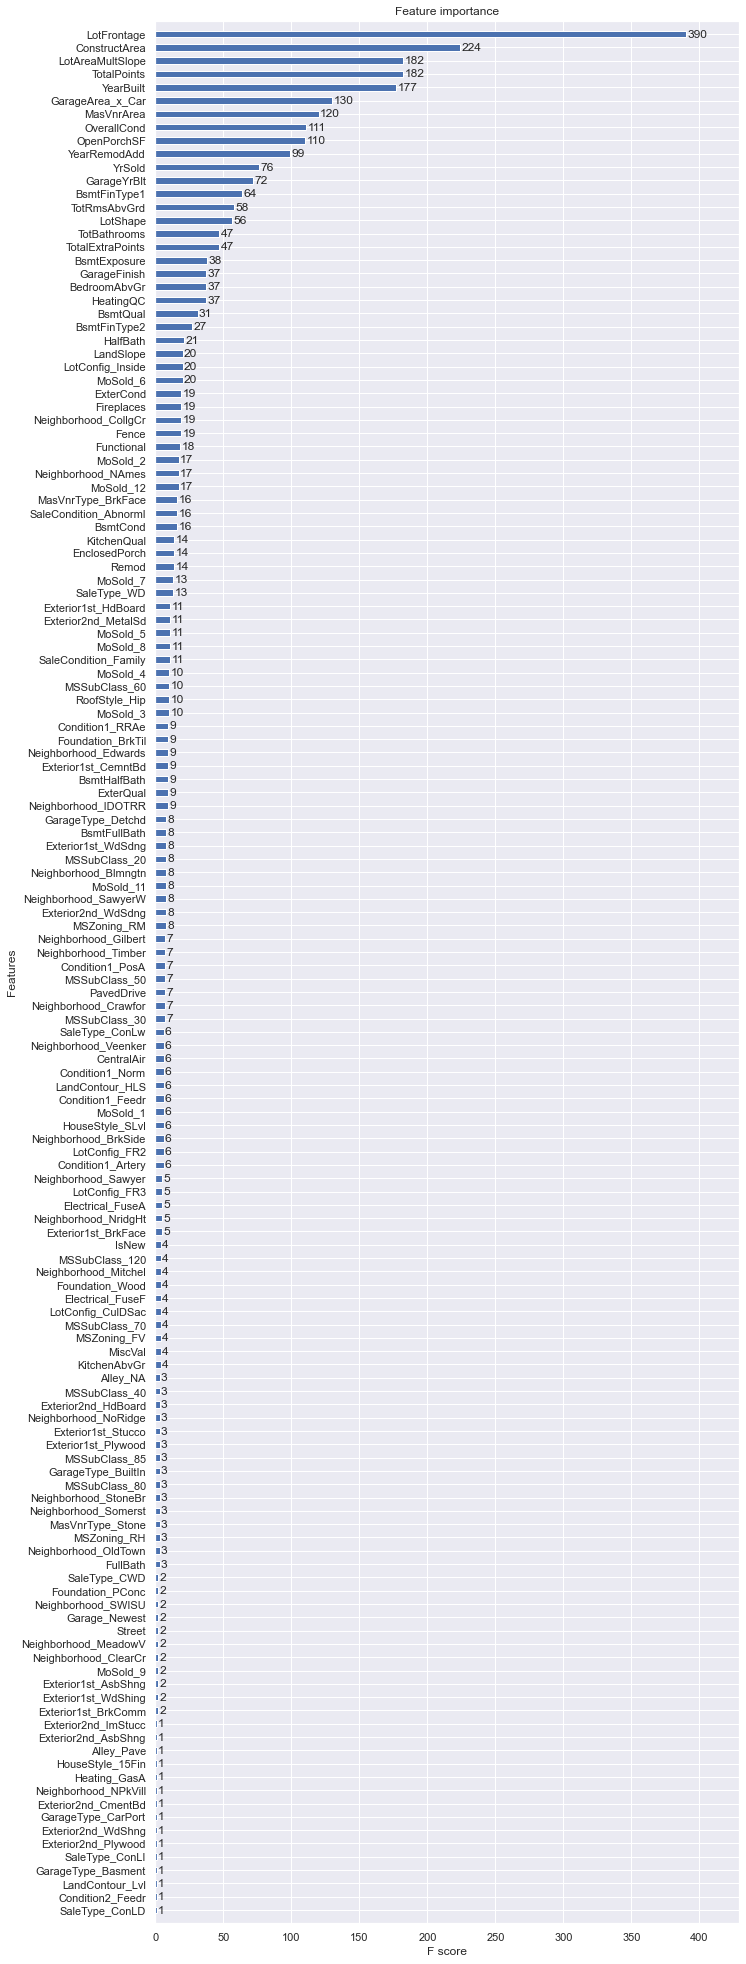

In [23]:
#Ploteamos para revisar
fig = plt.figure(figsize = (23,35))
ax = fig.add_subplot(121)
g = plot_importance(model, height = 0.5, ax = ax)

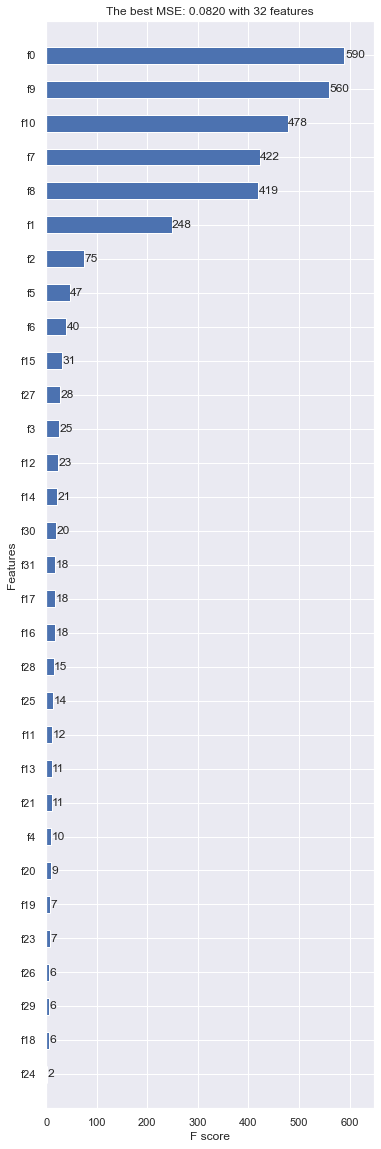

Sumary:
The best MSE was obtained with 32 features
Selected features: ['MSSubClass_70' 'TotalExtraPoints' 'ConstructArea' 'Exterior1st_BrkComm'
 'MSZoning_RM' 'Neighborhood_Crawfor' 'LandContour_Lvl' 'FullBath'
 'Neighborhood_IDOTRR' 'Exterior1st_BrkFace' 'SaleType_ConLD'
 'Condition2_Feedr' 'MoSold_12' 'YearBuilt' 'SaleCondition_Abnorml'
 'MoSold_3' 'SaleCondition_Family' 'Neighborhood_Somerst'
 'GarageType_Basment' 'Condition1_Artery' 'MSSubClass_85' 'BsmtQual'
 'YearRemodAdd' 'BsmtHalfBath' 'PavedDrive' 'Exterior1st_AsbShng'
 'Neighborhood_Edwards' 'LotAreaMultSlope' 'MSZoning_FV'
 'Neighborhood_StoneBr' 'Functional' 'GarageArea_x_Car']
    Score                Feature
0  0.1048  MSSubClass_70        
1  0.1009  TotalExtraPoints     
2  0.0871  ConstructArea        
3  0.0758  Exterior1st_BrkComm  
4  0.0456  MSZoning_RM          
5  0.0364  Neighborhood_Crawfor 
6  0.0337  LandContour_Lvl      
7  0.0308  FullBath             
8  0.0293  Neighborhood_IDOTRR  
9  0.0261  Exterior1st

In [24]:
#Ahora iremos probando con todos los valores de importancia como threshold para 
#ir viendo qué cantidad de features es la óptima (para lo cual primero fit y luego evaluamos usando R2 y MSE)

thresholds = np.sort(np.unique(model.feature_importances_)) #tomo todos los valores únicos de importance y los ordeno de menor a mayor
best = 1e36
colsbest = 31
my_model = model
threshold = 0

#Utilizo el metodo SelectFromModel para seleccionar los features son threshold >= al vigente
for thresh in thresholds:
    selection = SelectFromModel(model, threshold = thresh, prefit = True)
    select_X_train = selection.transform(X_train) ##crea un X con los feats seleccionados
    
    #train the model of selected features
    selection_model = XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0, max_delta_step=0, 
                                    random_state=101, min_child_weight=1, missing=None, n_jobs=4, 
                                    scale_pos_weight=1, seed=None, silent=True, subsample=1, verbosity = 0)
    selection_model.fit(select_X_train, y)
    
    #Evaluate the fitted model
    select_X_test = selection.transform(X_test) #test set with selected features
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred] #redondeo los valores de la predicción
    r2 = r2_score(y_test, predictions) #calculo el R2
    mse = mean_squared_error(y_test, predictions) #calculo el MSE
#     print("Thresh={:1.3f}, n={:d}, R2: {:2.2%} with MSE: {:.4f}".format(thresh, select_X_train.shape[1], r2, mse))
    
    #select the best 
    if best >= mse:
        best = mse
        colsbest = select_X_train.shape[1]
        my_model = selection_model
        threshold = thresh
        
        
#Present results
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(131)
g = plot_importance(my_model, height = 0.5, ax = ax, title='The best MSE: {:1.4f} with {:d} features'.\
                    format(best, colsbest))  
plt.show()
#Create a summary
feature_importances = [(score, feature) for score, feature in zip(model.feature_importances_, cols)] #todas las feat importance
XGBest = pd.DataFrame(sorted(feature_importances, reverse= True)[:colsbest], columns = ["Score", "Feature"])
Xgb_selected_feats = XGBest["Feature"].values
print("Sumary:")
print("The best MSE was obtained with {} features".format(colsbest))
print("Selected features:",Xgb_selected_feats )
print(XGBest)




In [25]:
###UNIMOS LOS FEATURES SELECCIONADOS POR TODOS LOS METODOS
#Unidos todos los features seleccionados por los 5 métodos:
bcols_mae = set(pv_cols).union(set(sel_cols_rfecv)).union(set(SBS)).union(set(kbest_FR)).union(set(kbest_MIR)).union(set(Xgb_selected_feats))

In [26]:
#Veamos qué features aportó cada método que no aportaron los otros

In [27]:
#Seleccionados diferenciales por kbest_FR:
set(kbest_FR).difference(set(pv_cols).union(set(sel_cols_rfecv)).union(set(SBS)).union(set(kbest_MIR)).union(set(Xgb_selected_feats)))

{'Alley_NA', 'Condition1_Feedr', 'Heating_GasA', 'Heating_Grav'}

In [28]:
##Seleccionados diferenciales por kbest_MIR:
set(kbest_MIR).difference(set(pv_cols).union(set(sel_cols_rfecv)).union(set(SBS)).union(set(kbest_FR)).union(set(Xgb_selected_feats)))

{'ExterCond', 'Exterior1st_CemntBd', 'Exterior2nd_CmentBd'}

In [29]:
#Seleccionados diferenciales por RFECV:
set(sel_cols_rfecv).difference(set(pv_cols).union(set(SBS)).union(set(kbest_FR)).union(set(kbest_MIR)).union(set(Xgb_selected_feats)))

{'Alley_Pave', 'Exterior1st_Plywood', 'MiscFeature_Shed'}

In [30]:
#seleccionados diferenciales por SBS
set(SBS).difference(set(pv_cols).union(set(sel_cols_rfecv)).union(set(kbest_FR)).union(set(kbest_MIR)).union(set(Xgb_selected_feats)))

set()

In [31]:
#Seleccionados diferenciales por xgboost...
set(Xgb_selected_feats).difference(set(pv_cols).union(set(sel_cols_rfecv)).union(set(SBS)).union(set(kbest_FR)).union(set(kbest_MIR)))

{'Condition2_Feedr',
 'Exterior1st_BrkComm',
 'FullBath',
 'GarageType_Basment',
 'SaleType_ConLD'}

In [32]:
#Seleccionados diferenciales por Recursive Feature mae (pv)
set(pv_cols).difference(set(sel_cols_rfecv).union(set(SBS)).union(set(kbest_FR)).union(set(kbest_MIR)).union(set(Xgb_selected_feats)))

{'Condition1_RRAn',
 'Condition2_Artery',
 'Exterior1st_AsphShn',
 'Exterior1st_Stucco',
 'Exterior1st_WdShing',
 'Exterior2nd_BrkFace',
 'Exterior2nd_Stone',
 'HouseStyle_15Unf',
 'MSSubClass_120',
 'MSSubClass_190',
 'MSSubClass_40',
 'MSSubClass_75',
 'MiscFeature_Othr',
 'MiscFeature_Pool',
 'MoSold_1',
 'MoSold_2',
 'MoSold_6',
 'MoSold_8',
 'MoSold_9',
 'Neighborhood_Blmngtn',
 'Neighborhood_Blueste',
 'Neighborhood_NPkVill',
 'Neighborhood_SWISU',
 'Neighborhood_Veenker',
 'RoofMatl_TarGrv',
 'RoofMatl_WdShake',
 'RoofStyle_Gambrel',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'SaleCondition_AdjLand',
 'SaleCondition_Alloca',
 'Street'}

In [33]:
print("Union of all features selected total:", len(bcols_mae))

Union of all features selected total: 160


In [34]:
##COMO EL VIEJO COMETIO UN ERROR EN Kbest_MIR, VAMOS A USAR SU SELECCION ACA PARA EFECTOS DE REPRODUCIBILIDAD DE LO QUE VIENE
bcols = {'Alley_NA',
 'Alley_Pave',
 'BedroomAbvGr',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtQual',
 'CentralAir',
 'Condition1_Artery',
 'Condition1_Feedr',
 'Condition1_Norm',
 'Condition1_RRAe',
 'Condition1_RRAn',
 'Condition2_Artery',
 'Condition2_Feedr',
 'ConstructArea',
 'Electrical_FuseA',
 'Electrical_FuseF',
 'EnclosedPorch',
 'ExterCond',
 'ExterQual',
 'Exterior1st_AsbShng',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_BrkFace',
 'Exterior1st_CemntBd',
 'Exterior1st_HdBoard',
 'Exterior1st_Plywood',
 'Exterior1st_Stucco',
 'Exterior1st_WdSdng',
 'Exterior1st_WdShing',
 'Exterior2nd_AsbShng',
 'Exterior2nd_BrkFace',
 'Exterior2nd_CmentBd',
 'Exterior2nd_HdBoard',
 'Exterior2nd_MetalSd',
 'Exterior2nd_Plywood',
 'Exterior2nd_Stone',
 'Exterior2nd_WdSdng',
 'Fence',
 'Fireplaces',
 'Foundation_BrkTil',
 'Foundation_PConc',
 'Foundation_Slab',
 'FullBath',
 'Functional',
 'GarageArea_x_Car',
 'GarageFinish',
 'GarageType_Basment',
 'GarageType_BuiltIn',
 'GarageType_CarPort',
 'GarageType_Detchd',
 'GarageType_NA',
 'GarageYrBlt',
 'Garage_Newest',
 'HalfBath',
 'HeatingQC',
 'Heating_GasA',
 'Heating_GasW',
 'Heating_Grav',
 'HouseStyle_15Fin',
 'HouseStyle_15Unf',
 'HouseStyle_SFoyer',
 'HouseStyle_SLvl',
 'IsNew',
 'KitchenAbvGr',
 'KitchenQual',
 'LandContour_Lvl',
 'LandSlope',
 'LotAreaMultSlope',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_Inside',
 'LotFrontage',
 'LotShape',
 'MSSubClass_120',
 'MSSubClass_160',
 'MSSubClass_180',
 'MSSubClass_190',
 'MSSubClass_20',
 'MSSubClass_30',
 'MSSubClass_40',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_70',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSZoning_FV',
 'MSZoning_RM',
 'MasVnrArea',
 'MasVnrType_BrkFace',
 'MasVnrType_Stone',
 'MiscFeature_Othr',
 'MiscFeature_Pool',
 'MiscFeature_Shed',
 'MoSold_1',
 'MoSold_11',
 'MoSold_12',
 'MoSold_2',
 'MoSold_3',
 'MoSold_4',
 'MoSold_5',
 'MoSold_6',
 'MoSold_7',
 'MoSold_8',
 'MoSold_9',
 'Neighborhood_Blmngtn',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Neighborhood_Timber',
 'Neighborhood_Veenker',
 'OpenPorchSF',
 'OverallCond',
 'PavedDrive',
 'Remod',
 'RoofMatl_CompShg',
 'RoofMatl_TarGrv',
 'RoofMatl_WdShake',
 'RoofMatl_WdShngl',
 'RoofStyle_Gambrel',
 'RoofStyle_Hip',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'SaleCondition_Abnorml',
 'SaleCondition_AdjLand',
 'SaleCondition_Alloca',
 'SaleCondition_Family',
 'SaleType_ConLD',
 'SaleType_WD',
 'Street',
 'TotBathrooms',
 'TotRmsAbvGrd',
 'TotalExtraPoints',
 'TotalPoints',
 'YearBuilt',
 'YearRemodAdd',
 'YrSold'}



In [35]:
##FINAL SUMMARY:
print("Union of all features selected total:", len(bcols))
print("Features that will be left out from the original set if we use this final selection:", cols.difference(bcols))

Union of all features selected total: 160
Features that will be left out from the original set if we use this final selection: Index(['BldgType_2fmCon', 'BldgType_Twnhs', 'Condition1_PosA',
       'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Norm',
       'Condition2_PosA', 'Condition2_PosN', 'Electrical_FuseP',
       'Exterior2nd_AsphShn', 'Exterior2nd_BrkCmn', 'Exterior2nd_ImStucc',
       'Exterior2nd_Stucco', 'Exterior2nd_WdShng', 'Foundation_Stone',
       'Foundation_Wood', 'Heating_Wall', 'HouseStyle_25Unf',
       'LandContour_HLS', 'LandContour_Low', 'LotConfig_FR3', 'MSZoning_RH',
       'MiscVal', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLI',
       'SaleType_ConLw', 'SaleType_Oth'],
      dtype='object')


In [36]:
%store -r new_poly_features



In [37]:
####ENSAMBLE DE FEATURES DESPUÉS DE FEATURE SELECTION
"""Agregaremos los features bcols (que reemplaza ya al original cols) seleccionados a new_poly_features (que creamos antes)
y formamos con eso
el set de features actualizado en total_cols"""
total_cols = list(bcols.union(set(new_poly_features.columns))) #unimos las columnas
len(total_cols)
total_cols
 

['HouseStyle_15Unf',
 'Exterior2nd_CmentBd',
 'LotConfig_FR2',
 'MSSubClass_80',
 'KitchenAbvGr',
 'Exterior1st_WdShing',
 'KitchenQual',
 'Exterior1st_AsbShng',
 'Condition1_Feedr',
 'Neighborhood_Sawyer',
 'ConstructArea_LotAreaMultSlope',
 'MSSubClass_40',
 'Neighborhood_ClearCr',
 'Garage_Newest',
 'Exterior2nd_BrkFace',
 'Exterior1st_Stucco',
 'Alley_Pave',
 'Condition2_Feedr',
 'MSSubClass_75',
 'Electrical_FuseF',
 'BsmtCond',
 'Neighborhood_Edwards',
 'TotalPoints^2',
 'Condition1_RRAe',
 'GarageYrBlt',
 'TotalPoints_LotAreaMultSlope',
 'MSSubClass_180',
 'HeatingQC',
 'Condition1_Artery',
 'Neighborhood_Blueste',
 'ConstructArea_TotalPoints',
 'GarageFinish',
 'ExterQual',
 'ConstructArea',
 'Exterior2nd_AsbShng',
 'MoSold_5',
 'MSSubClass_30',
 'Neighborhood_BrDale',
 'HalfBath',
 'MSSubClass_50',
 'Remod',
 'TotalPoints_LotAreaMultSlope^2',
 'MoSold_12',
 'MiscFeature_Pool',
 'RoofStyle_Shed',
 'MiscFeature_Shed',
 'LotAreaMultSlope^2',
 'TotalPoints^2_LotAreaMultSlope',
 'B

In [38]:
all_data.shape

(2908, 256)

In [39]:
all_data["LotFrontage"].head()

0   19.1088
1   21.8404
2   19.6734
3   18.1447
4   22.5339
Name: LotFrontage, dtype: float64

In [40]:
###ACTUALIZACION DE TRAIN Y TEST ANTES DE PASAR A MODELING

# #Creo el train y se resetea también su index
train = all_data.round(3).iloc[:len(y_train), :]
train = train.loc[:, list(total_cols)].reset_index(drop = True, inplace = False)

# #Creo el test y se resetea también su index
test = all_data.round(3).iloc[len(y_train):, :]
test= test.loc[:, list(total_cols)].reset_index(drop = True, inplace = False)

# #Reseteo además el y_train en su index

y_train = y_train.reset_index(drop = True, inplace = False)

train.shape

(1449, 190)

In [41]:
#####DIMENSIONALITY REDUCTION VIA PRINCIPAL COMPONENT ANALYSIS

In [42]:
"""Excelente explicación en este link: https://www.youtube.com/watch?v=AniiwysJ-2Y&list=PLs8w1Cdi-zvZ43xD_AA-eAuEW1FLK0cef&index=6"""

'Excelente explicación en este link: https://www.youtube.com/watch?v=AniiwysJ-2Y&list=PLs8w1Cdi-zvZ43xD_AA-eAuEW1FLK0cef&index=6'

In [43]:
#Haremos una reducción dimensional de la data utilizando  PCA:
#Escalamos los datos: es un requisito antes de aplicar PCA
scale = RobustScaler() 
df = scale.fit_transform(train)

pca = PCA().fit(df) # whiten=True

print('With only 120 features: {:6.4%} of the variance was captured'.format(sum(pca.explained_variance_ratio_[:120])),"\n")

print('After PCA, {:3} features only left not explained {:6.4%} of variance ratio from the original {:3}'.format(120,
                                                                                    (sum(pca.explained_variance_ratio_[120:])),
                                                                                    df.shape[1]))

With only 120 features: 99.8725% of the variance was captured 

After PCA, 120 features only left not explained 0.1275% of variance ratio from the original 190


In [44]:
sum(pca.explained_variance_ratio_[:120])


0.9987252226760344

In [45]:
"""Nota: el número de features seleccionados fue elegido a criterio. Uno puede elegir seteando pca en n_components_ = m, lo que arrojará
los m mejores componentes proyectados. En este caso se dejó m = 190 pero se cortó en 120 para mostrar que con 120 ya se tenía
el 99.9% de la varianza explicada (es decir, se captura el 99.9% de la información de los datos originales)"""

'Nota: el número de features seleccionados fue elegido a criterio. Uno puede elegir seteando pca en n_components_ = m, lo que arrojará\nlos m mejores componentes proyectados. En este caso se dejó m = 190 pero se cortó en 120 para mostrar que con 120 ya se tenía\nel 99.9% de la varianza explicada (es decir, se captura el 99.9% de la información de los datos originales)'

In [48]:
class select_fetaures(object): # BaseEstimator, TransformerMixin, 
    def __init__(self, select_cols):
        self.select_cols_ = select_cols

    def fit(self, X, Y ):
        print('Received {0:2d} features...'.format(X.shape[1]))
        return self

    def transform(self, X):
        print('Select {0:2d} features'.format(X.loc[:, self.select_cols_].shape[1]))
        return X.loc[:, self.select_cols_]    

    def fit_transform(self, X, Y):
        self.fit(X, Y)
        df = self.transform(X)
        return df 
        #X.loc[:, self.select_cols_]    

    def __getitem__(self, x):
        return self.X[x], self.Y[x]
        

In [49]:
def get_results(model, name='NAN', log=False):
    
    rcols = ['Name','Model', 'BestParameters', 'Scorer', 'Index', 'BestScore', 'BestScoreStd', 'MeanScore', 
             'MeanScoreStd', 'Best']
    res = pd.DataFrame(columns=rcols)
    results = gs.cv_results_
    modelo = gs.best_estimator_

    scoring = {'MAE': 'neg_mean_absolute_error', 'R2': 'r2', 'RMSE': 'neg_mean_squared_error'}

    for scorer in sorted(scoring):
        best_index = np.nonzero(results['rank_test_%s' % scoring[scorer]] == 1)[0][0]
        if scorer == 'RMSE': 
            best = np.sqrt(-results['mean_test_%s' % scoring[scorer]][best_index])
            best_std = np.sqrt(results['std_test_%s' % scoring[scorer]][best_index])
            scormean = np.sqrt(-results['mean_test_%s' % scoring[scorer]].mean())
            stdmean = np.sqrt(results['std_test_%s' % scoring[scorer]].mean())
            if log:
                best = np.expm1(best)
                best_std = np.expm1(best_std)
                scormean = np.expm1(scormean)
                stdmean = np.expm1(stdmean)
        elif scorer == 'MEA':
            best = (-results['mean_test_%s' % scoring[scorer]][best_index])
            best_std = results['std_test_%s' % scoring[scorer]][best_index]
            scormean =(-results['mean_test_%s' % scoring[scorer]].mean())
            stdmean = results['std_test_%s' % scoring[scorer]].mean()
            if log:
                best = np.expm1(best)
                best_std = np.expm1(best_std)
                scormean = np.expm1(scormean)
                stdmean = np.expm1(stdmean)
        else:
            best = results['mean_test_%s' % scoring[scorer]][best_index]*100
            best_std = results['std_test_%s' % scoring[scorer]][best_index]*100
            scormean = results['mean_test_%s' % scoring[scorer]].mean()*100
            stdmean = results['std_test_%s' % scoring[scorer]].mean()*100
        
        r1 = pd.DataFrame([(name, modelo, gs.best_params_, scorer, best_index, best, best_std, scormean, 
                            stdmean, gs.best_score_)],
                          columns = rcols)
        res = res.append(r1)
        
    if log:
        bestscore = np.expm1(np.sqrt(-gs.best_score_))
    else:
        bestscore = np.sqrt(-gs.best_score_)
        
    print("Best Score: {:.6f}".format(bestscore))
    print('---------------------------------------')
    print('Best Parameters:')
    print(gs.best_params_)
    
    return res

In [50]:
model = Pipeline([
        ('pca', PCA(random_state = 101)),
        ('model', Lasso(random_state = 101))]) 

SEL = list(set(sel_cols_rfecv).union(set(new_poly_features.columns)))
n_components = [len(SEL)-5, len(SEL)-3, len(SEL)] 
whiten = [False, True]
max_iter = [5] #, 10, 100, 200, 300, 400, 500, 600]  
alpha = [0.0003, 0.0007, 0.0005, 0.05, 0.5, 1.0]
selection = ['random', 'cyclic'] 
tol = [2e-03, 0.003, 0.001, 0.0005]
param_grid =\
            dict(
                  model__alpha = alpha
                  ,model__max_iter = max_iter
                  ,model__selection = selection
                  ,model__tol = tol
                  ,pca__n_components = n_components
                  ,pca__whiten = whiten 
                ) 

gs = GridSearchCV(estimator = model, param_grid = param_grid, refit = 'neg_mean_squared_error' #, iid=False
                   , scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=5, verbose=1, n_jobs=4)

lasso = Pipeline([
        ('sel', select_fetaures(select_cols=SEL)), 
        ('scl', RobustScaler()),
        ('gs', gs)
 ])

lasso.fit(train,y_train)

results = get_results(lasso, 'lasso Lg1', log=True)
display(results.loc[:, 'Scorer' : 'MeanScoreStd'])
r = residuals_plots(lasso, train, y_train, log=True)

Received 190 features...
Select 109 features
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 1260 tasks      | elapsed:    9.0s


Best Score: 0.116419
---------------------------------------
Best Parameters:
{'model__alpha': 0.0007, 'model__max_iter': 5, 'model__selection': 'random', 'model__tol': 0.002, 'pca__n_components': 106, 'pca__whiten': True}


[Parallel(n_jobs=4)]: Done 1440 out of 1440 | elapsed:    9.8s finished


,Scorer,Index,BestScore,BestScoreStd,MeanScore,MeanScoreStd
0,MAE,51,-7.7109,0.2878,-14.2141,0.5693
0,R2,51,92.3635,0.2231,69.2846,0.7427
0,RMSE,51,0.1164,0.0262,0.2474,0.0649


NameError: name 'resilduals_plots' is not defined